# Programming Assignment #5: Convolutional Networks
Author: Pierre Nugues

In [ ]:
Filip Bergman, Erik Rolander

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the type of flowers in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `chapter09_part03_interpreting-what-convnets-learn.ipynb`. You can download from https://github.com/fchollet/deep-learning-with-python-notebooks.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU (Unless you have a GPU on your machine). This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. Register to Kaggle (https://www.kaggle.com/) to collect the datset used in this experiment. It is free and you will have access to lots of datasets. If you do not want to register, go to step 2.
2. Download the Flower corpus:
   * Either from Kaggle if you have registered (https://www.kaggle.com/alxmamaev/flowers-recognition). 
   * Or use a local copy, `flower-recognition.zip`, in the `datasets` folder in canvas.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
   * Start with the partition available in the canvas folder (`flower_split.zip`); or
   * Run the code in the cells below (recommended).


In [102]:
import os
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

# The machine name. Use the name colab is you run the code from Google colab
machine_name = 'fe'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [103]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

In [104]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'pierre':
    base = '/Users/pierre/Documents/Cours/EDAN95/datasets/'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = './'

In [105]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


['./flowers\\daisy',
 './flowers\\dandelion',
 './flowers\\rose',
 './flowers\\sunflower',
 './flowers\\tulip']

We build the (image, label) pairs

In [106]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('100080576_f52e8ee070_n.jpg', 'daisy'),
 ('10140303196_b88d3d6cec.jpg', 'daisy'),
 ('10172379554_b296050f82_n.jpg', 'daisy'),
 ('10172567486_2748826a8b.jpg', 'daisy'),
 ('10172636503_21bededa75_n.jpg', 'daisy'),
 ('102841525_bd6628ae3c.jpg', 'daisy'),
 ('10300722094_28fa978807_n.jpg', 'daisy'),
 ('1031799732_e7f4008c03.jpg', 'daisy'),
 ('10391248763_1d16681106_n.jpg', 'daisy'),
 ('10437754174_22ec990b77_m.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [107]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [108]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the training set. You can start from the architecture proposed by Chollet, Listing 8.7 (in Chollet's notebook chapter 8), and a small number of epochs. Use the `Rescaling` layer to scale your images as in the book:
```
layer.Rescaling(1.255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [2]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

Create the network and compile it

In [110]:
# Write your code here
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="sigmoid")(x)
outputs = layers.Dense(5, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Compile your network

In [111]:
# Write your code here
model.compile(loss="binary_crossentropy",
              optimizer=OPTIMIZER,
              metrics=["accuracy"])

In [112]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_188 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_189 (Conv2D)         (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

Create now the data readers for the training, validation, and test sets

In [113]:
# Write your code here
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(180, 180),
    batch_size=32,
    labels="inferred",
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(180, 180),
    batch_size=32,
    labels="inferred",
    label_mode='categorical')
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32,
    labels="inferred",
    label_mode='categorical')



Found 2590 files belonging to 5 classes.
Found 863 files belonging to 5 classes.
Found 864 files belonging to 5 classes.


You will now fit your model. Before, you will define a callback as in Chollet's book.

In [114]:
# Write your callback here
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [115]:
# Write your fitting code here
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
81/81 [==============================] - 11s 94ms/step - loss: 0.4638 - accuracy: 0.3888 - val_loss: 0.4017 - val_accuracy: 0.5087
Epoch 2/30
81/81 [==============================] - 7s 85ms/step - loss: 0.3751 - accuracy: 0.5436 - val_loss: 0.4310 - val_accuracy: 0.5423
Epoch 3/30
81/81 [==============================] - 7s 86ms/step - loss: 0.3334 - accuracy: 0.6178 - val_loss: 0.3112 - val_accuracy: 0.6315
Epoch 4/30
81/81 [==============================] - 7s 82ms/step - loss: 0.2964 - accuracy: 0.6707 - val_loss: 0.2901 - val_accuracy: 0.6663
Epoch 5/30
81/81 [==============================] - 7s 86ms/step - loss: 0.2623 - accuracy: 0.7154 - val_loss: 0.3067 - val_accuracy: 0.6582
Epoch 6/30
81/81 [==============================] - 7s 84ms/step - loss: 0.2235 - accuracy: 0.7668 - val_loss: 0.2943 - val_accuracy: 0.6860
Epoch 7/30
81/81 [==============================] - 7s 87ms/step - loss: 0.1862 - accuracy: 0.8069 - val_loss: 0.3226 - val_accuracy: 0.6732
Epoch 8/30
8

### Analyzing the fitting performance over epochs

As in Chollet's examples, show the training and validation loss

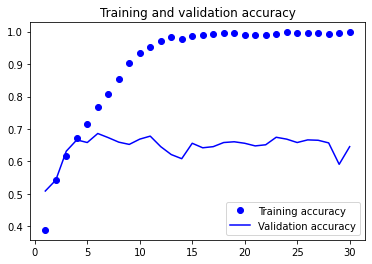

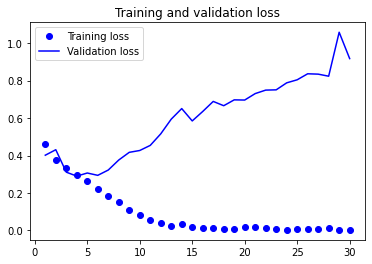

In [116]:
# Write your code here
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()




In [117]:
#for i, batch in enumerate(train_dataset):
#    images, labels = batch
#    fig, ax = plt.subplots(1, 5, figsize=(60,  9))
#    for j, image in enumerate(images):
#        plotim = image
#        print(plotim)
#        print(labels[j])
#        ax[j].imshow(plotim)
#        
#        if j == 4:
#            break
#    break
#plt.show()

### Predicting the test set

You will now apply now your network to the test set. Read the best model from your checkpoints

In [118]:
# Write your code here
test_model = keras.models.load_model("convnet_from_scratch.keras")

Predict the test set classes. Call the matrix of prediction probabilities `Y_pred` and the predicted classes `y_pred`. While predicting, extract the annotations that you will call `y_true`.

In [119]:
# Write your code here
Y_pred = test_model.predict(test_dataset)
y_pred = []
y_true = []
for image, label in test_dataset:
    y_true = np.concatenate([y_true, np.argmax(label.numpy(), axis=-1)])
    y_pred = np.concatenate([y_pred, np.argmax(test_model.predict(image), axis=-1)])

In [120]:
Y_pred[:5]

array([[0.05983392, 0.05576977, 0.13992234, 0.1825517 , 0.03930414],
       [0.06426671, 0.02517932, 0.20495592, 0.01192726, 0.63638645],
       [0.02083645, 0.00162523, 0.62490964, 0.00249416, 0.31113172],
       [0.01491379, 0.00229544, 0.30484074, 0.0224339 , 0.79958457],
       [0.15181802, 0.58668214, 0.06889595, 0.00522655, 0.07467671]],
      dtype=float32)

In [121]:
y_pred[:5]

array([2., 1., 0., 4., 1.])

In [122]:
print(y_true[:5])
print(len(y_true))

[2. 1. 0. 4. 1.]
864


Evaluate your model and report the loss and accuracy using Keras `evaluate()` function. You will store them in the `test_loss_1` and `test_acc_1` variables.

In [123]:
# Write your code here
test_loss_1, test_acc_1 = test_model.evaluate(test_dataset)

27/27 [==============================] - 1s 34ms/step - loss: 0.3012 - accuracy: 0.6771


In [124]:
test_loss_1, test_acc_1

(0.30116117000579834, 0.6770833134651184)

Report the accuracy as well as the classification report. Use sklearn functions this time.

In [125]:
# Write your code here
from sklearn import metrics

print((metrics.classification_report(y_true, y_pred)))

              precision    recall  f1-score   support

         0.0       0.66      0.75      0.70       174
         1.0       0.76      0.64      0.70       204
         2.0       0.66      0.53      0.59       155
         3.0       0.65      0.79      0.72       141
         4.0       0.65      0.69      0.67       190

    accuracy                           0.68       864
   macro avg       0.68      0.68      0.67       864
weighted avg       0.68      0.68      0.67       864



Print the confusion matrix. Use a sklearn function

In [126]:
# Write your code here
metrics.confusion_matrix(y_true, y_pred)

array([[130,  19,   5,  12,   8],
       [ 27, 130,   5,  33,   9],
       [ 17,   8,  82,   3,  45],
       [ 10,   9,   1, 112,   9],
       [ 13,   4,  31,  11, 131]], dtype=int64)

Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides built-in layers for this. You will reuse them and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 8.13 (in notebook 08 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

Write a sequence of transformation layers

In [127]:
# Write your code here
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


Define a model including these layers.

In [128]:
# Write your code here
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="sigmoid")(x)
outputs = layers.Dense(5, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Compile your network

In [129]:
# Write your code
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [130]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_192 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_193 (Conv2D)         (None, 87, 87, 64)        18496     
                                                          

Define a callback to save your best model

In [131]:
# Write your code here
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [132]:
# Write your code here
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
81/81 [==============================] - 10s 100ms/step - loss: 0.4749 - accuracy: 0.3726 - val_loss: 0.4037 - val_accuracy: 0.4844
Epoch 2/30
81/81 [==============================] - 8s 95ms/step - loss: 0.3819 - accuracy: 0.5359 - val_loss: 0.3445 - val_accuracy: 0.5863
Epoch 3/30
81/81 [==============================] - 8s 95ms/step - loss: 0.3490 - accuracy: 0.5903 - val_loss: 0.3369 - val_accuracy: 0.6095
Epoch 4/30
81/81 [==============================] - 7s 89ms/step - loss: 0.3266 - accuracy: 0.6243 - val_loss: 0.2973 - val_accuracy: 0.6825
Epoch 5/30
81/81 [==============================] - 7s 88ms/step - loss: 0.3049 - accuracy: 0.6510 - val_loss: 0.3115 - val_accuracy: 0.6431
Epoch 6/30
81/81 [==============================] - 8s 97ms/step - loss: 0.2911 - accuracy: 0.6726 - val_loss: 0.2651 - val_accuracy: 0.7068
Epoch 7/30
81/81 [==============================] - 7s 86ms/step - loss: 0.2824 - accuracy: 0.6710 - val_loss: 0.2787 - val_accuracy: 0.6987
Epoch 8/30


### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

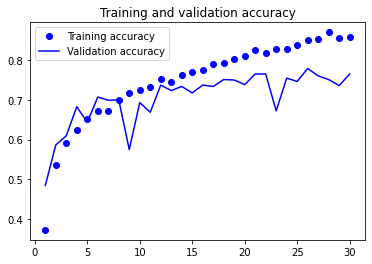

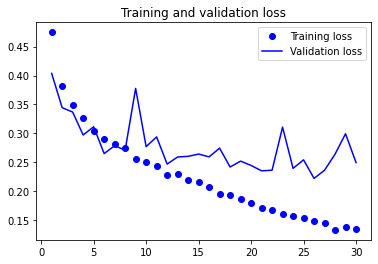

In [133]:
# Write your code here
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

Load your best model

In [134]:
# Write your code here
test_model = keras.models.load_model("convnet_from_scratch.keras")

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [135]:
# Write your code here
test_loss_2, test_acc_2 = test_model.evaluate(test_dataset)

27/27 [==============================] - 1s 36ms/step - loss: 0.2330 - accuracy: 0.7708 0s - loss: 0.2469 


In [136]:
test_loss_2, test_acc_2

(0.23299209773540497, 0.7708333134651184)

## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [5]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

As in Chollet, Listing 8.20 (in Chollet's notebook 08), you will program a `get_features_and_labels()` function.

In [63]:
# Write your code
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.inception_v3.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
    

The features and labels

In [64]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [65]:
train_features.shape

(2590, 4, 4, 2048)

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [66]:
# Write your code
inputs = keras.Input(shape=(4, 4, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
pretrained_model = keras.Model(inputs, outputs)

In [67]:
pretrained_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4, 4, 2048)]      0         
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 8,390,149
Trainable params: 8,390,149
Non-trainable params: 0
_________________________________________________________________


Compile your model

In [68]:
# Write your code
pretrained_model.compile(loss="binary_crossentropy",
              optimizer=OPTIMIZER,
              metrics=["accuracy"])

Define a callback to save your best model

In [69]:
# Write your code here
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

Fit your network

In [70]:
# Write your code here
history = pretrained_model.fit(
    train_features, train_labels,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
81/81 [==============================] - 2s 23ms/step - loss: 12.6140 - accuracy: 0.6421 - val_loss: 5.6417 - val_accuracy: 0.7474
Epoch 2/30
81/81 [==============================] - 2s 19ms/step - loss: 6.2563 - accuracy: 0.7869 - val_loss: 4.6930 - val_accuracy: 0.7949
Epoch 3/30
81/81 [==============================] - 2s 20ms/step - loss: 4.1142 - accuracy: 0.8371 - val_loss: 4.0815 - val_accuracy: 0.8239
Epoch 4/30
81/81 [==============================] - 1s 17ms/step - loss: 3.2170 - accuracy: 0.8768 - val_loss: 6.3330 - val_accuracy: 0.7532
Epoch 5/30
81/81 [==============================] - 1s 15ms/step - loss: 2.5892 - accuracy: 0.9019 - val_loss: 5.8769 - val_accuracy: 0.7949
Epoch 6/30
81/81 [==============================] - 1s 16ms/step - loss: 2.1052 - accuracy: 0.9104 - val_loss: 4.9497 - val_accuracy: 0.8030
Epoch 7/30
81/81 [==============================] - 1s 16ms/step - loss: 1.8133 - accuracy: 0.9197 - val_loss: 4.6185 - val_accuracy: 0.8216
Epoch 8/30
8

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

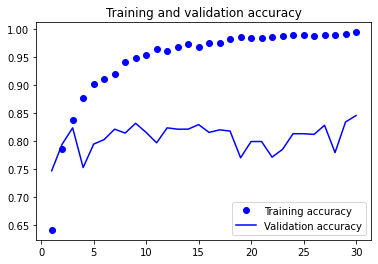

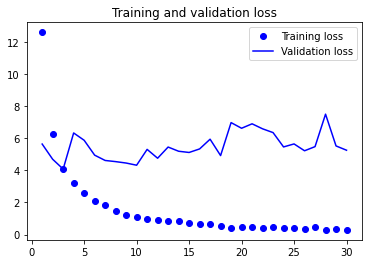

In [71]:
# Write your code here
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load your best model from the file

In [72]:
# Write your code here
test_model = keras.models.load_model("feature_extraction.keras")

Evaluate your model and store the loss and accuracy in `test_loss_3`, `test_acc_3`

In [73]:
# Write your code here
test_loss_3, test_acc_3 = test_model.evaluate(test_features, test_labels)

27/27 [==============================] - 0s 6ms/step - loss: 3.2220 - accuracy: 0.8345


In [74]:
test_loss_3, test_acc_3

(3.221968650817871, 0.8344907164573669)

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, use nadam or rmsprop as optimizer. Rescaling seems to lower the accuracy. Do not use it in your first attempts.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [75]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))

You may want to try this first, and possibly modify it to improve the scores

In [76]:
conv_base.trainable = False

Create an image augmentation

In [77]:
# Write you code
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Create your model

In [86]:
# Write you code
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Compile it

In [87]:
# Write your code
model.compile(loss="binary_crossentropy",
              optimizer=OPTIMIZER,
              metrics=["accuracy"])

In [88]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0   

Write a callback to save your best model

In [89]:
# Write your code here
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

Fit the model

In [91]:
# Write your code
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
81/81 [==============================] - 14s 174ms/step - loss: 14.9293 - accuracy: 0.5931 - val_loss: 15.5901 - val_accuracy: 0.5516
Epoch 2/30
81/81 [==============================] - 13s 153ms/step - loss: 6.4254 - accuracy: 0.7448 - val_loss: 3.5316 - val_accuracy: 0.8239
Epoch 3/30
81/81 [==============================] - 12s 142ms/step - loss: 4.3252 - accuracy: 0.7888 - val_loss: 7.0391 - val_accuracy: 0.7138
Epoch 4/30
81/81 [==============================] - 12s 141ms/step - loss: 3.0569 - accuracy: 0.8131 - val_loss: 6.2002 - val_accuracy: 0.6547
Epoch 5/30
81/81 [==============================] - 13s 153ms/step - loss: 2.1644 - accuracy: 0.8050 - val_loss: 2.7115 - val_accuracy: 0.7775
Epoch 6/30
81/81 [==============================] - 12s 141ms/step - loss: 1.4049 - accuracy: 0.8402 - val_loss: 3.2992 - val_accuracy: 0.7231
Epoch 7/30
81/81 [==============================] - 13s 154ms/step - loss: 0.9311 - accuracy: 0.8344 - val_loss: 1.7743 - val_accuracy: 0.77

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

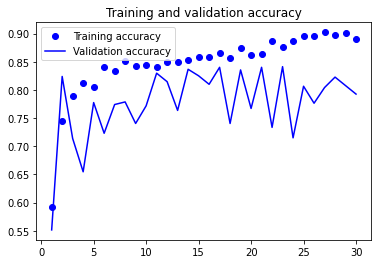

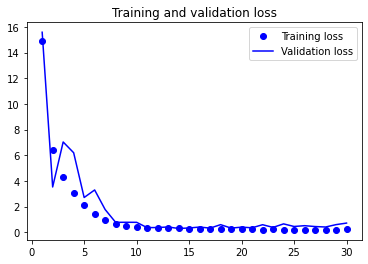

In [92]:
# write your code
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load your best model

In [93]:
# Write your code here
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")

Evaluate it and store the loss and accuracy in `test_loss_4` and `test_acc_4`

In [96]:
# Write your code here
test_loss_4, test_acc_4 = test_model.evaluate(test_dataset)

27/27 [==============================] - 3s 89ms/step - loss: 0.2368 - accuracy: 0.8542


In [97]:
test_loss_4, test_acc_4

(0.2367725670337677, 0.8541666865348816)

### Predicting the test set

Apply now your network to the test set. You will collect `y_true` and `y_pred`

In [98]:
# Write your code here
#Y_pred = test_model.predict(test_dataset)
y_pred = []
y_true = []
for image, label in test_dataset:
    y_true = np.concatenate([y_true, np.argmax(label.numpy(), axis=-1)])
    y_pred = np.concatenate([y_pred, np.argmax(test_model.predict(image), axis=-1)])

Report the accuracy as well as the classification report. Use sklearn functions

In [99]:
# write your code
from sklearn import metrics

print((metrics.classification_report(y_true, y_pred)))

              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       174
         1.0       0.82      0.94      0.88       204
         2.0       0.82      0.86      0.84       155
         3.0       0.86      0.81      0.84       141
         4.0       0.84      0.80      0.82       190

    accuracy                           0.85       864
   macro avg       0.86      0.85      0.85       864
weighted avg       0.86      0.85      0.85       864



Print the confusion matrix

In [100]:
# write your code
metrics.confusion_matrix(y_true, y_pred)

array([[146,  14,   2,   7,   5],
       [  1, 192,   1,   6,   4],
       [  1,   6, 134,   2,  12],
       [  3,  12,   3, 114,   9],
       [  2,   9,  24,   3, 152]], dtype=int64)

## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [138]:
(test_loss_1, test_acc_1), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((0.30116117000579834, 0.6770833134651184),
 (0.23299209773540497, 0.7708333134651184),
 (3.221968650817871, 0.8344907164573669),
 (0.2367725670337677, 0.8541666865348816))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe all the architectures you designed and the results you obtained. You will summarize the results in a table. Your description should be one-page long;
2. You will run Chollet's notebook chapter09_part3 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. Your analysis should be about one-page long.
3. You will run it on one of your flower images.

You will submit your report as well as your notebook through Canvas.